In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set("talk", style="ticks")

from copy import deepcopy as copy
from astropy.io import fits

from astropy.visualization import make_lupton_rgb


import contextlib
import sys

import warnings
warnings.filterwarnings("ignore")

class DummyFile(object):
    def write(self, x): pass

@contextlib.contextmanager
def nostdout():
    save_stdout = sys.stdout
    sys.stdout = DummyFile()
    yield
    sys.stdout = save_stdout

In [14]:
experiment = "lmc-rss"
inp_path = "../../_fitting-data/LMC-MUSE"
obs_path = f'{inp_path}/cubes'
out_path = f'{inp_path}/out'
fig_path = f"{inp_path}/figs"

In [37]:
from PIL import Image, ImageEnhance
from lvmdap.analysis import img_scale


def create_RGB(Rdata, Gdata, Bdata):
    scale_flux = 0.7  # 2.5
    RGBdata = np.zeros((Bdata.shape[0], Bdata.shape[1], 3), dtype=float)
    RGBdata[:, :, 0] = img_scale.sqrt(
        Rdata*scale_flux * 1., scale_min=0.01, scale_max=2)
    RGBdata[:, :, 1] = img_scale.sqrt(
        Gdata*scale_flux * 0.9, scale_min=0.01, scale_max=2)
    RGBdata[:, :, 2] = img_scale.sqrt(
        Bdata*scale_flux * 1.1, scale_min=0.01, scale_max=2)

    RGBdata = RGBdata * 255
    RGBdata_int = RGBdata.astype('uint8')

    RGB_image = Image.fromarray(RGBdata_int)

    bright = ImageEnhance.Brightness(RGB_image)
    RGB_image = bright.enhance(1.2)
    contrast = ImageEnhance.Contrast(RGB_image)
    RGB_image = contrast.enhance(1.5)
    sharpness = ImageEnhance.Sharpness(RGB_image)
    RGB_image = sharpness.enhance(2.0)

    return RGB_image.__array__()


In [ ]:
# build a wiki page describing current DAP outputs
# share LMC outputs

In [261]:
!ls {out_path}/*{POINTING}*.fits.gz

../../_fitting-data/LMC-MUSE/out/LMC_115-dezonification.map.fits.gz
../../_fitting-data/LMC-MUSE/out/LMC_115-gas.cube.fits.gz
../../_fitting-data/LMC-MUSE/out/LMC_115-moments.cube.fits.gz
../../_fitting-data/LMC-MUSE/out/LMC_115-rsp.cube.fits.gz
../../_fitting-data/LMC-MUSE/out/output.LMC_115.fits.gz


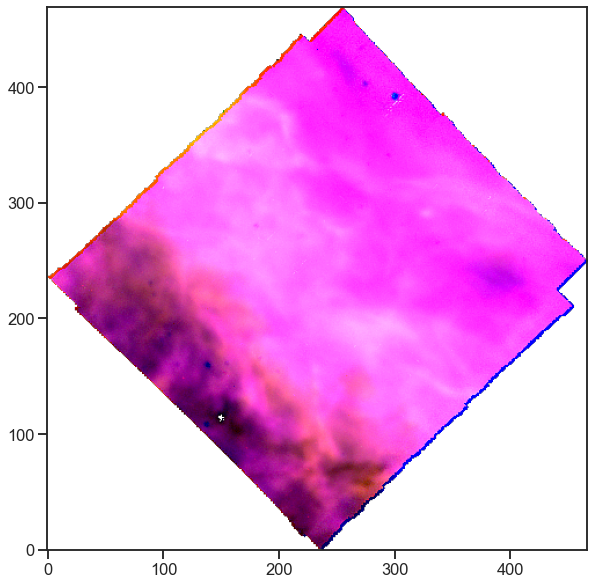

In [258]:
# POINTING = "LMC_043"
# POINTING = "LMC_061"
# POINTING = "LMC_086"
# POINTING = "LMC_090"
# POINTING = "LMC_098"
POINTING = "LMC_115"

gas_cube = fits.open(f"{out_path}/{POINTING}-moments.cube.fits.gz")
momana_cube, header = gas_cube[0].data, gas_cube[0].header

flux_elines_I0 = np.nan_to_num(momana_cube[:4], nan=9999)

mask = ~np.isnan(momana_cube[0].data).all(axis=0)

OIII_image = flux_elines_I0[0]
Ha_image = flux_elines_I0[2]
NII_image = (flux_elines_I0[1]+flux_elines_I0[3])

rgb_image = create_RGB(Ha_image, NII_image, OIII_image)
alpha = ~np.all(rgb_image==0, axis=2) * 255
rgba_image = np.dstack((rgb_image, alpha)).astype(int)

plt.figure(figsize=(10,10))
plt.imshow(rgba_image, origin="lower")

# plt.savefig(f"{POINTING}-RGB.jpeg", bbox_inches="tight")

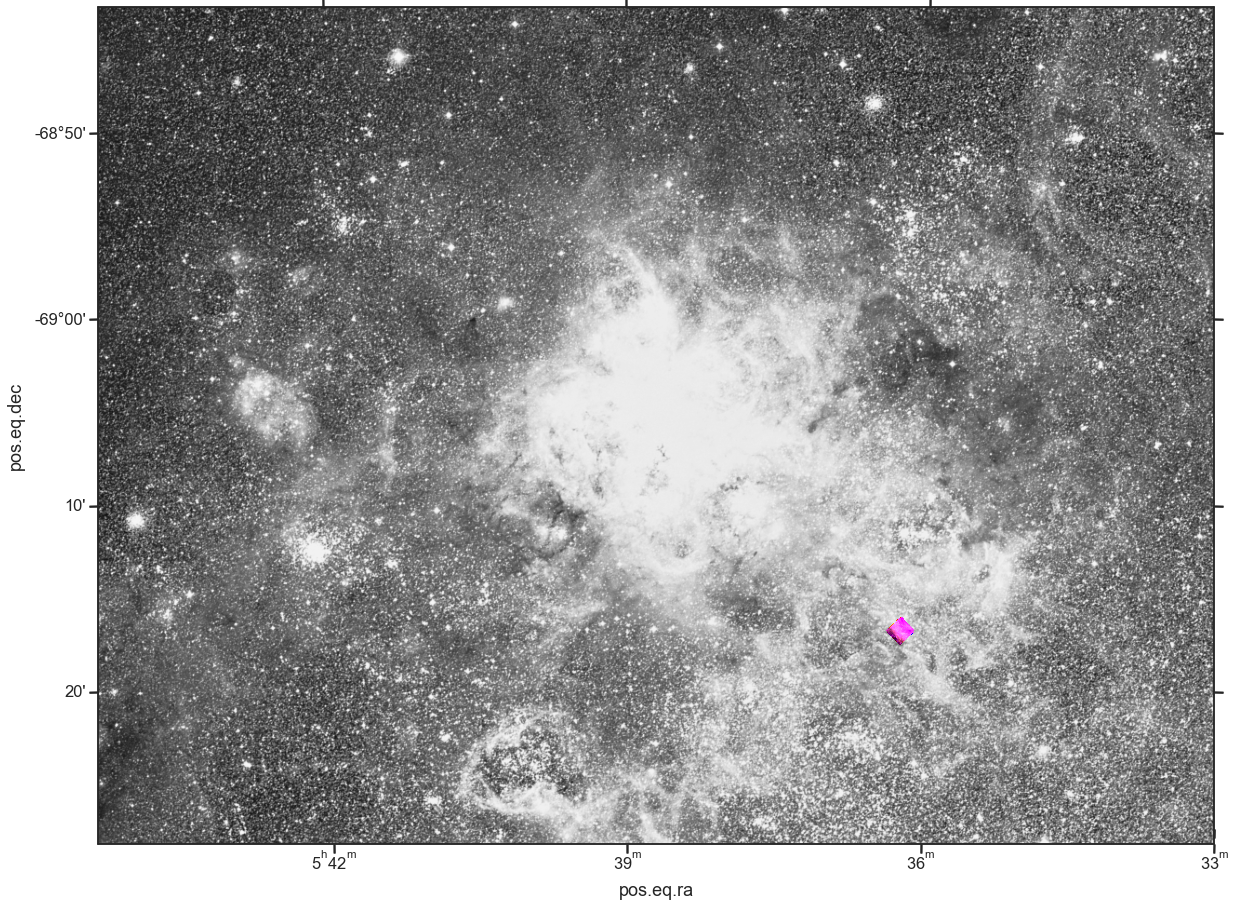

In [259]:
from astropy.wcs import WCS
from reproject import reproject_interp
from reproject.mosaicking import reproject_and_coadd
from reproject.mosaicking import find_optimal_celestial_wcs


lmc_image = fits.open(f"{inp_path}/30Dor-CDS_P_DSS2_blue.fits")
# lmc_image = fits.open(f"{inp_path}/LMC-CDS_P_DSS2_blue.fits")
lmc_blue, lmc_header = lmc_image[0].data, lmc_image[0].header

new_header = fits.Header()
new_header["NAXIS1"] = header["NAXIS1"]
new_header["NAXIS2"] = header["NAXIS2"]
new_header["CRPIX1"] = header["CRPIX1"]
new_header["CRPIX2"] = header["CRPIX2"]
new_header["CTYPE1"] = header["CTYPE1"]
new_header["CTYPE2"] = header["CTYPE2"]
new_header["CUNIT1"] = header["CUNIT1"]
new_header["CUNIT2"] = header["CUNIT2"]
new_header["CRVAL1"] = header["CRVAL1"]
new_header["CRVAL2"] = header["CRVAL2"]
new_header["CD1_1"] = header["CD1_1"]
new_header["CD1_2"] = header["CD1_2"]
new_header["CD2_1"] = header["CD2_1"]
new_header["CD2_2"] = header["CD2_2"]
hdu = fits.PrimaryHDU(header=new_header)
r_hdu = hdu.copy()
g_hdu = hdu.copy()
b_hdu = hdu.copy()

r_hdu.data = Ha_image
g_hdu.data = NII_image
b_hdu.data = OIII_image

wcs_out, shape_out = find_optimal_celestial_wcs([r_hdu])
r_mosaic, _ = reproject_and_coadd([r_hdu], wcs_out, shape_out=shape_out, reproject_function=reproject_interp)
g_mosaic, _ = reproject_and_coadd([g_hdu], wcs_out, shape_out=shape_out, reproject_function=reproject_interp)
b_mosaic, _ = reproject_and_coadd([b_hdu], wcs_out, shape_out=shape_out, reproject_function=reproject_interp)

fig, ax = plt.subplots(figsize=(20,20), subplot_kw={"projection": WCS(lmc_header)})
ax.imshow(lmc_blue, origin="lower", cmap="Greys_r")
rgb_mosaic = create_RGB(r_mosaic, g_mosaic, b_mosaic)
# rgb_mosaic = np.ma.masked_array(rgb_mosaic, mask=rgb_mosaic == 0)
rgba_mosaic = np.dstack((rgb_mosaic, ~np.all(rgb_image == 0, axis=2) * 255))
ax.imshow(rgba_mosaic, origin="lower", interpolation="none", transform=ax.get_transform(wcs_out))
ax.autoscale()


In [ ]:
# DAP: LMC pre-processing scripts (coadd, RSS, fitting, mosaic)
# DAP: improving moment analysis
# DAP: implementing random sampling in stellar component fitting
# DAP: pre-processing of MWM stars
# DAP: analysis with CoSHA
# DAP: description of data products in the wiki, with examples
# DAP: run end-to-end simulation
# DRP: in the middle of a re-factor
# DRP: started implementing wavelength solution refinement